In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from matplotlib.ticker import LogLocator
from IPython.display import display, HTML
from collections import namedtuple

def make_plot_look_good(axes):
    axes.axhline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.axvline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.grid(True, which='both', linestyle='--', linewidth=0.5)
    for spine in axes.spines.values():
        spine.set_visible(False)

def set_axes_labels(axes, x_label, y_label, title, legend_title=None):
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_title(title)
    if legend_title is not None:
        axes.legend(title=legend_title,bbox_to_anchor=(1,1))
    make_plot_look_good(axes)



# Simulation information

In [58]:
# compute the initial concentration of receptors
number_of_cells = 1e9
initial_receptors_per_cell = 10e4
avogadros_number = 6.022e23
blood_volume = 4 # liters
initial_receptor_concentration = number_of_cells * initial_receptors_per_cell / avogadros_number / blood_volume

# create a new subclass of namedtuple with the specific field names we want
# the first argument is the name of the tuple subclass we are creating. the second argument is a list of field names
StateVariableMetadata = namedtuple('StateVariableMetadata', ['description', 'initial_value', 'units'])

state_variable_metadata = {
    'L': StateVariableMetadata(description="Ligand (EGF)", initial_value=50e-11, units='M'),
    'A': StateVariableMetadata(description="ADAM10", initial_value=50e-11, units='M'),

    # SURFACE SPECIES
    'R1s': StateVariableMetadata(description="Surface Monomeric EGFR", initial_value=initial_receptor_concentration, units='M'),
    'R2s': StateVariableMetadata(description="Surface Monomeric HER2", initial_value=initial_receptor_concentration, units='M'),
    'R1/R2s': StateVariableMetadata(description="Surface Dimeric EGFR/HER2", initial_value=0, units='M'),
    'R1/R1s': StateVariableMetadata(description="Surface Dimeric EGFR/EGFR", initial_value=0, units='M'),
    'R2/R2s': StateVariableMetadata(description="Surface Dimeric HER2/HER2", initial_value=0, units='M'),
    'R1/Ls': StateVariableMetadata(description="Surface Ligand-bound EGFR", initial_value=0, units='M'),
    'R1/R1/Ls': StateVariableMetadata(description="Surface Singly Ligand-bound EGFR/EGFR", initial_value=0, units='M'),
    'L/R1/R1/Ls': StateVariableMetadata(description="Surface Doubly Ligand-bound EGFR/EGFR", initial_value=0, units='M'),
    'L/R1/R2s': StateVariableMetadata(description="Surface Ligand-bound EGFR/HER2", initial_value=0, units='M'),
    'shed': StateVariableMetadata(description="Surface shed ", initial_value=0, units='M'),

    # INTERNAL SPECIES
    'R1i': StateVariableMetadata(description="Internal Monomeric EGFR", initial_value=0, units='M'),
    'R2i': StateVariableMetadata(description="Internal Monomeric HER2", initial_value=0, units='M'),
    'R1/R2i': StateVariableMetadata(description="Internal Dimeric EGFR/HER2", initial_value=0, units='M'),
    'R1/R1i': StateVariableMetadata(description="Internal Dimeric EGFR/EGFR", initial_value=0, units='M'),
    'R2/R2i': StateVariableMetadata(description="Internal Dimeric HER2/HER2", initial_value=0, units='M'),
    'R1/Li': StateVariableMetadata(description="Internal Ligand-bound EGFR", initial_value=0, units='M'),
    'R1/R1/Li': StateVariableMetadata(description="Internal Singly Ligand-bound EGFR/EGFR", initial_value=0, units='M'),
    'L/R1/R1/Li': StateVariableMetadata(description="Internal Doubly Ligand-bound EGFR/EGFR", initial_value=0, units='M'),
    'L/R1/R2i': StateVariableMetadata(description="Internal Ligand-bound EGFR/HER2", initial_value=0, units='M')
}

rate_constants = {
    # dimerization and uncoupling parameters; taken from Hendriks 2003 
    'k_c': 1e-3* number_of_cells / avogadros_number / blood_volume,         # /( #/cell min )   same for all dimers! 
    'k_uR1/R1': 10,      # /min
    'k_uR1/R2': 10,      # /min
    'k_uR2/R2': 1,       # /min
    'k_uR1/R1/L': 1,     # /min (guess)
    'k_uL/R1/R2': 0.1,   # /min
    'k_uL/R1/R1/L': 0.1,   # /min

    # EGF association with EGFR; taken from Hendriks 2003 
    'k_on': 9.7e7,       # /(M min) 
    'k_off': 0.24,        # /min

    # internalization; taken from Hendriks 2003 plus assumptions
    'k_eR1': 0.01,
    'k_eR2': 0.01,       # /min    this is 0.01 WITHOUT EGF, else 0.03!
    'k_edimer': 0.04,    # /min    assumed to be equal for all dimers (value pulled from paper for k_eR1/R1)
    'k_eR1/L': 0.28,     # /min
    'k_edimer/L':0.1,    # /min    assumed to be equal for all dimers and singly/doubly bound ligand (value pulled from paper for L/R1/R2)
    'k_eshed': 0.1,

    # degradation; 
    'k_degdimer': 0.02,
    'k_degdimer/L': 0.02,
    'k_degR1': 0.02,
    'k_degR1/L': 0.02,
    'k_degR2': 0.02,

     # synthesis of surface R1 and R2 (assumed equal) 
    'V_s': 1000, #* number_of_cells / avogadros_number / blood_volume,  # /min    assume same as pset

    # shedding
    'k_shed': 10   # potentially Kcat = 10-10000 /sec according to GPT for proteases in general; 
                   # Km ranges from 1uM to 1mM for many protease-substrate pairs
 }



In [59]:
1e-3 * number_of_cells / avogadros_number / blood_volume

4.151444702756559e-19

# Implement dxdt function
This is the heart of the simulation. By default, `dydt` takes two arguments, t and y. The optional `args` parameter to `solve_ivp` will be used to pass the rate constant and state variable information to dydt. 

In [60]:

# Define dx/dt function
def dydt(t, y, rate_constants, state_variable_metadata):
    # the state variables y are in a vector that is based on order. this makes for confusing code.
    # the following lines assign programmer-friendly names to the state variables by creating a dictionary with keys equal to the variable names
    # this approach also makes it easy to add or remove state variables -- just edit state_variable_metadata
    state_variable_values = dict( zip( state_variable_metadata.keys(), y ) )

    derivatives = dict()

    derivatives['L'] = (
        - rate_constants['k_on']*state_variable_values['L']*(state_variable_values['R1/R1s'] +
                                                             state_variable_values['R1s'] +
                                                             state_variable_values['R1/R2s'] +
                                                             state_variable_values['R1/R1/Ls'])
        + rate_constants['k_off']*(state_variable_values['R1/R1/Ls'] +
                                  state_variable_values['R1/Ls'] +
                                  state_variable_values['L/R1/R2s'] +
                                  state_variable_values['L/R1/R1/Ls'])                                                  
    )

    derivatives['A'] = 0

    # SURFACE DERIVATIVES
    derivatives['R1/R1s'] = (
        rate_constants['k_c']*state_variable_values['R1s']**2
        - rate_constants['k_uR1/R1']*state_variable_values['R1/R1s']
        - rate_constants['k_edimer']*state_variable_values['R1/R1s']
        - rate_constants['k_on']*state_variable_values['R1/R1s']*state_variable_values['L']
        + rate_constants['k_off']*state_variable_values['R1/R1/Ls']
    )
    derivatives['R1/R1/Ls'] = (
        rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R1/Ls']
        - rate_constants['k_uR1/R1/L']*state_variable_values['R1/R1/Ls']
        - rate_constants['k_edimer/L']*state_variable_values['R1/R1/Ls']
        + rate_constants['k_on']*state_variable_values['R1/R1s']*state_variable_values['L']
        - rate_constants['k_off']*state_variable_values['R1/R1/Ls']
    )
    derivatives['L/R1/R1/Ls'] = (
        rate_constants['k_c']*state_variable_values['R1/Ls']**2
        - rate_constants['k_uL/R1/R1/L']*state_variable_values['L/R1/R1/Ls']
        - rate_constants['k_edimer/L']*state_variable_values['L/R1/R1/Ls']
        + rate_constants['k_on']*state_variable_values['R1/R1/Ls']*state_variable_values['L']
        - rate_constants['k_off']*state_variable_values['L/R1/R1/Ls']
    )
    derivatives['R2/R2s'] = (
        rate_constants['k_c']*state_variable_values['R2s']**2
        - rate_constants['k_uR2/R2']*state_variable_values['R2/R2s']
        - rate_constants['k_edimer']*state_variable_values['R2/R2s']
    )
    derivatives['R1/R2s'] = (
        rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R2s']
        - rate_constants['k_uR1/R2']*state_variable_values['R1/R2s']
        - rate_constants['k_edimer']*state_variable_values['R1/R2s']
        - rate_constants['k_on']*state_variable_values['R1/R2s']*state_variable_values['L']
        + rate_constants['k_off']*state_variable_values['L/R1/R2s']
    )
    derivatives['L/R1/R2s'] = (
        rate_constants['k_c']*state_variable_values['R1/Ls']*state_variable_values['R2s']
        - rate_constants['k_uL/R1/R2']*state_variable_values['L/R1/R2s']
        - rate_constants['k_edimer/L']*state_variable_values['L/R1/R2s']
        + rate_constants['k_on']*state_variable_values['R1/R2s']*state_variable_values['L']
        - rate_constants['k_off']*state_variable_values['L/R1/R2s']
    )
    derivatives['R1/Ls'] = (
        rate_constants['k_on']*state_variable_values['R1s']*state_variable_values['L']
        - rate_constants['k_off']*state_variable_values['R1/Ls']
        - rate_constants['k_c']*state_variable_values['R1/Ls']*state_variable_values['R2s']
        - 2*rate_constants['k_c']*state_variable_values['R1s']**2
        + 2*rate_constants['k_uL/R1/R1/L']*state_variable_values['L/R1/R1/Ls']
        + rate_constants['k_uL/R1/R2']*state_variable_values['L/R1/R2s']
        - rate_constants['k_eR1/L']*state_variable_values['R1/Ls']
    )
    derivatives['R1s'] = (
        - rate_constants['k_eR1']*state_variable_values['R1s']
        - 2*rate_constants['k_c']*state_variable_values['R1s']**2
        - rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R2s']
        - rate_constants['k_on']*state_variable_values['R1s']*state_variable_values['L']
        + 2*rate_constants['k_uR1/R1']*state_variable_values['R1/R1s']
        + rate_constants['k_uR1/R2']*state_variable_values['R1/R2s']
        + rate_constants['k_off']*state_variable_values['R1/Ls']
        + rate_constants['k_uR1/R1/L']*state_variable_values['R1/R1/Ls']
        - rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R1/Ls']
        + rate_constants['V_s']
    )
    derivatives['R2s'] = (
        - rate_constants['k_eR2']*state_variable_values['R2s']
        - rate_constants['k_shed']*state_variable_values['R2s']*state_variable_values['A']
        - 2*rate_constants['k_c']*state_variable_values['R2s']**2
        - rate_constants['k_c']*state_variable_values['R1s']*state_variable_values['R2s']
        + 2*rate_constants['k_uR2/R2']*state_variable_values['R2/R2s']
        + rate_constants['k_uR1/R2']*state_variable_values['R1/R2s']
        + rate_constants['k_uL/R1/R2']*state_variable_values['L/R1/R2s']
        - rate_constants['k_c']*state_variable_values['R2s']*state_variable_values['R1/Ls']
        + rate_constants['V_s']
    )
    derivatives['shed'] = (
        rate_constants['k_shed']*state_variable_values['A']*state_variable_values['R2s']
        - rate_constants['k_eshed']*state_variable_values['shed']
    )

    # INTERNAL DERIVATIVES
    derivatives['R1/R1i'] = (
        rate_constants['k_edimer']*state_variable_values['R1/R1s']
        - rate_constants['k_degdimer']*state_variable_values['R1/R1i']
    )
    derivatives['R1/R1/Li'] = (
        rate_constants['k_edimer/L']*state_variable_values['R1/R1/Ls']
        - rate_constants['k_degdimer/L']*state_variable_values['R1/R1/Li']
    )
    derivatives['L/R1/R1/Li'] = (
        rate_constants['k_edimer/L']*state_variable_values['L/R1/R1/Ls']
        - rate_constants['k_degdimer/L']*state_variable_values['L/R1/R1/Li']
    )
    derivatives['R2/R2i'] = (
        rate_constants['k_edimer']*state_variable_values['R2/R2s']
        - rate_constants['k_degdimer']*state_variable_values['R2/R2i']
    )
    derivatives['R1/R2i'] = (
        rate_constants['k_edimer']*state_variable_values['R1/R2s']
        - rate_constants['k_degdimer']*state_variable_values['R1/R2i']
    )
    derivatives['L/R1/R2i'] = (
        rate_constants['k_edimer/L']*state_variable_values['R1/R1/Ls']
        - rate_constants['k_degdimer/L']*state_variable_values['L/R1/R2i']
    )
    derivatives['R1/Li'] = (
        rate_constants['k_eR1/L']*state_variable_values['R1/Ls']
        - rate_constants['k_degR1/L']*state_variable_values['R1/Li']
    )
    derivatives['R1i'] = (
        rate_constants['k_eR1']*state_variable_values['R1s']
        - rate_constants['k_degR1']*state_variable_values['R1i']
    )
    derivatives['R2i'] = (
        rate_constants['k_eR2']*state_variable_values['R2s']
        - rate_constants['k_degR2']*state_variable_values['R2i']
    )

    # convert the 'derivatives' dictionary back to a vector because that is what solve_ivp requires
    return [ derivatives[key] for key in state_variable_metadata.keys()]


# Run the simulation and plot results

In [61]:

# this function takes the rate constant dictionary and state variable metadata dictionary and runs a simulation
# with the specified parameters. if you want to change the parameters, put different values in rate_constants or
# state_variable_metadata.
def simulate_binding_recycling_and_degradation(t, rate_constants, state_variable_metadata):
    # concatenate state variable initial values into a list
    x_initial_value = np.array( [ iv.initial_value for iv in state_variable_metadata.values() ] )

    # call solve_ivp. this problem is stiff, so it is necessary to use an algorithm that can handle stiff systems.
    solution = solve_ivp( dydt, [t[0], t[-1]], x_initial_value, 
                         args=(rate_constants, state_variable_metadata),
                         t_eval=t, 
                         atol=1e-20, 
                         dense_output=True,
                         method='Radau')

    # create a dictionary with keys equal to state variable names and values equal to simulation
    # this is handy for plotting or just accessing the state variable values
    simulation_results_dictionary = dict( (key, value) for key, value in zip(state_variable_metadata.keys(), solution.y) )
    # add time axis to results
    simulation_results_dictionary['t'] = t

    return simulation_results_dictionary, solution


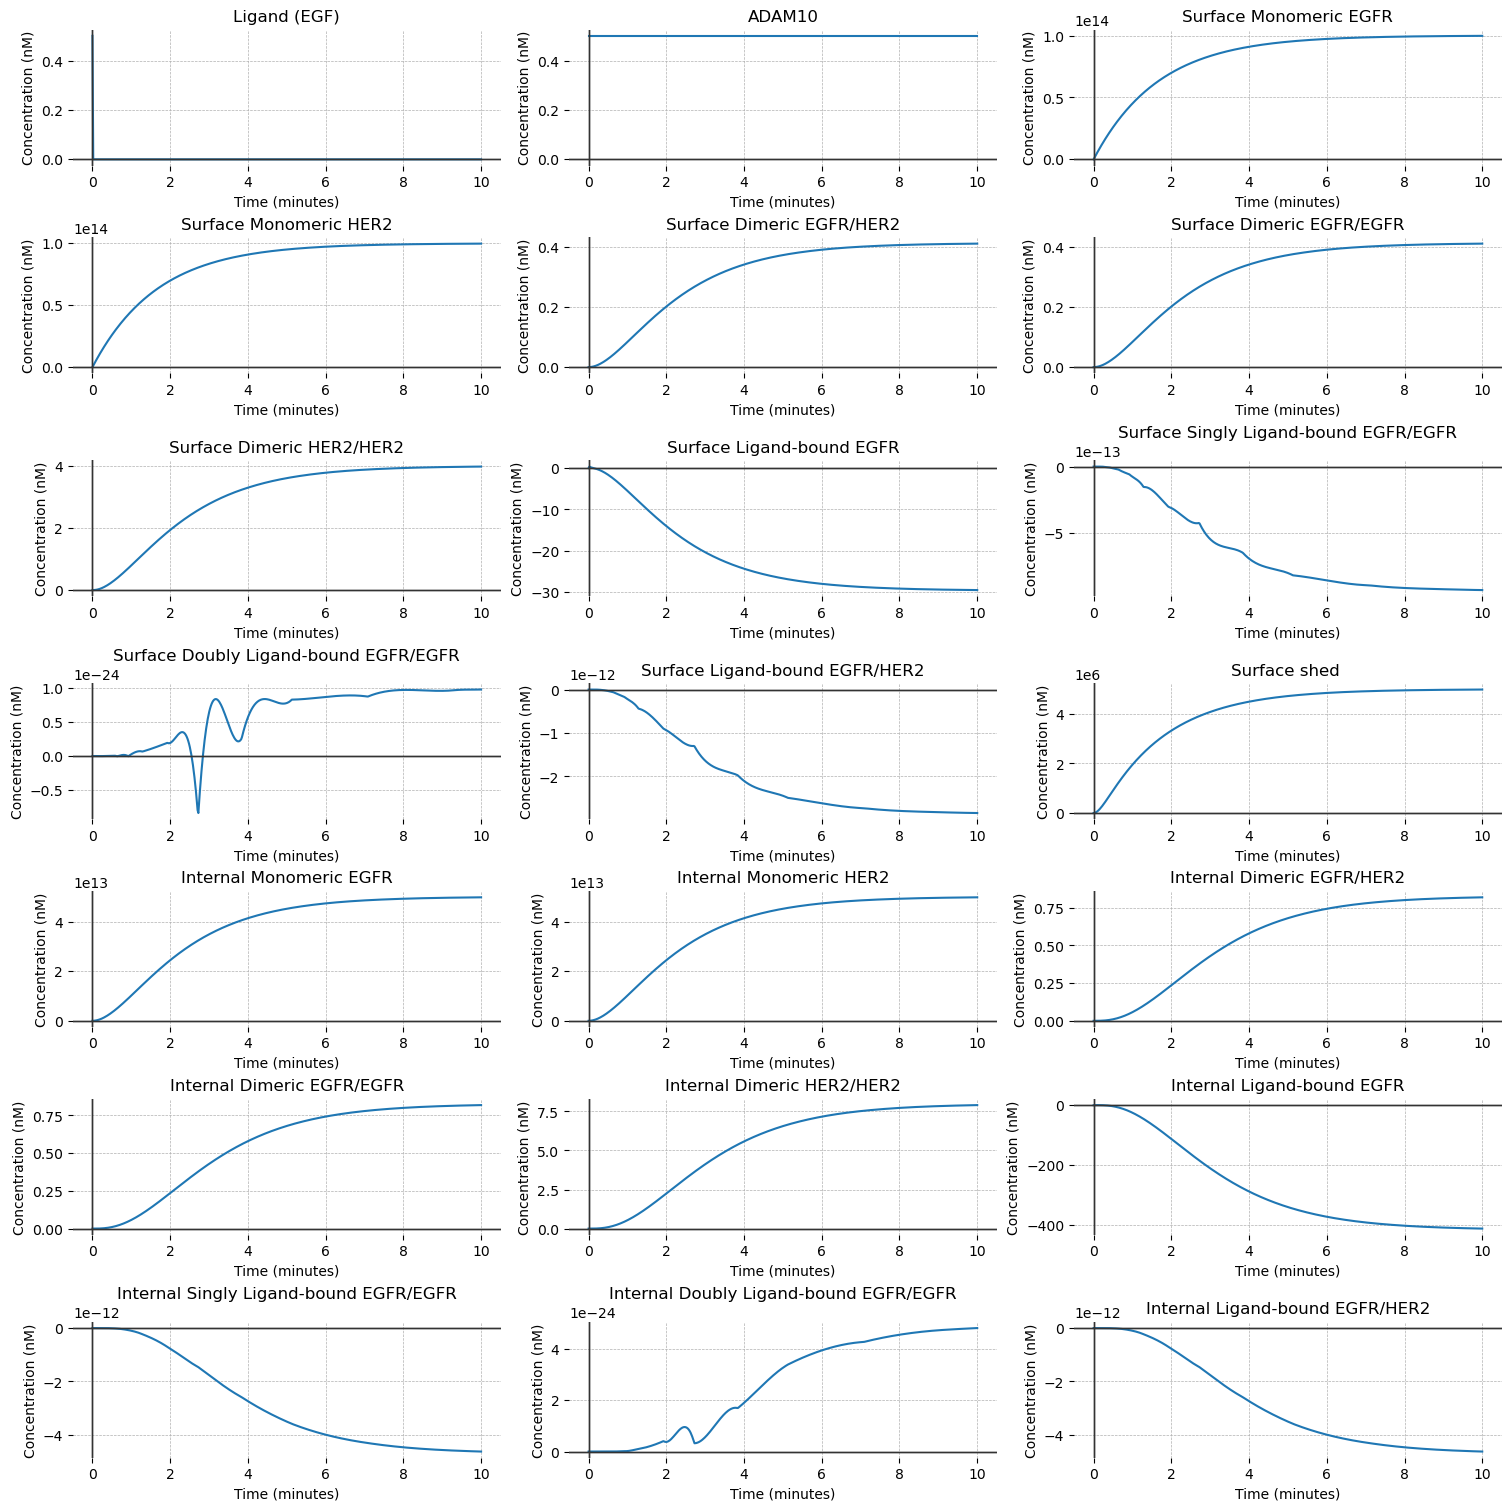

In [62]:

# create time axis
simulation_time_mins = 10  # 500 minutes, as in problem statement
t = np.linspace(0, simulation_time_mins*60, 500)

# Run the simulation
simulation_results, solution = simulate_binding_recycling_and_degradation(t, rate_constants, state_variable_metadata)
# plot for each of the state variables. it's not a bad idea in any simulation to have a look at everything 
# to ensure all of the variables
fig, axes = plt.subplots(7, 3, figsize=(15, 15), layout="constrained")
axes = axes.flatten()
# fig.suptitle(f'Initial ligand concentration: {ligand} M; initial Pemigatinib concentration: {inhibitor} M\n\n')


plot_time_axis = simulation_results['t']/60

for ax, (key, state_variable) in zip(axes,state_variable_metadata.items()):
    ax.plot(plot_time_axis, simulation_results[key]*1e9)

    set_axes_labels(ax, 'Time (minutes)', 'Concentration (nM)', state_variable.description)
    make_plot_look_good(ax)

plt.show()